In [1]:
import numpy as np
from typing import *

from perception.cam import *
from perception.perc import *
from perception.pcd_utils import *

# jax
import jax
import jax.numpy as jnp
from flax import linen as nn
from flax.training import orbax_utils
import orbax
from jaxlie import SO3, SE3
import jax_dataclasses as jdc

#sdf world
from sdf_world.sdf_world import *
from sdf_world.robots import *
from sdf_world.util import *
from sdf_world.network import *
from sdf_world.ik import *
from sdf_world.robot_model import *
from sdf_world.opt_planner import *

from jaxlie import SE3, SO3
from scipy.interpolate import CubicSpline
import time
import cyipopt

import rospy
from sensor_msgs.msg import JointState
from std_msgs.msg import Float64MultiArray
from trajectory_msgs.msg import JointTrajectory, JointTrajectoryPoint
from control_msgs.msg import GripperCommand

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
class KinovaROS:
    SET_CONFIG_KP = 0
    SET_CONFIG_KI = 1
    SET_CONFIG_GAMMA = 2
    SET_CONFIG_POS_CTRL_MODE = 3
    NORMAL_PID = 0
    GRAVITY_COMPENSATION_ONLY = 1

    def __init__(self, node, vel_limit):
        self.node = node
        self.vel_limit = vel_limit
        self.joint_state = {}
        self.robot_state = {}
        self.joint_names = [f"joint_{i+1}" for i in range(7)]
        
        def joint_states_cb(msg):
            self.joint_state["q"] = np.array(msg.position)
            self.joint_state["dq"] = np.array(msg.velocity)
        def robot_states_cb(msg):
            self.robot_state["pos_ctrl_mode"] = msg.data[0]
            self.robot_state["is_traj_following"] = msg.data[1]
            self.robot_state["kp"] = msg.data[2:9]
            self.robot_state["ki"] = msg.data[9:16]
            self.robot_state["gamma"] = msg.data[16:23]

        self.joint_states_sub = rospy.Subscriber('/gen3/joint_state', JointState, joint_states_cb)
        self.robot_states_sub = rospy.Subscriber('/gen3/robot_state', Float64MultiArray, robot_states_cb)
        self.robot_config_pub = rospy.Publisher('/gen3/robot_config', Float64MultiArray, queue_size=1)
        self.trajectory_pub = rospy.Publisher('/gen3/joint_traj', JointTrajectory, queue_size=1)
        self.gripper_cmd_pub = rospy.Publisher('/gen3/gripper_cmd', GripperCommand, queue_size=1)
        # self.joint_desired_pub = rospy.Publisher('/joint_state', JointState, queue_size=1)
        # self.pos_ctrl_mode_pub = rospy.Publisher('/pos_ctrl_mode', Int32MultiArray, queue_size=1)
    
    @property
    def q_curr(self):
        return self.joint_state['q']
    
    def set_pos_ctrl_mode(self, mode):
        msg = Float64MultiArray()
        if mode == "gravity":
            msg.data = [self.SET_CONFIG_POS_CTRL_MODE, self.GRAVITY_COMPENSATION_ONLY]
        elif mode == "pid":
            msg.data = [self.SET_CONFIG_POS_CTRL_MODE, self.NORMAL_PID]
        self.robot_config_pub.publish(msg)
    
    def set_ctrl_gain(self, gaintype, gain):
        assert len(gain) == 7
        if gaintype == "kp":
            config_enum = self.SET_CONFIG_KP
        elif gaintype == "ki":
            config_enum = self.SET_CONFIG_KI
        elif gaintype == "gamma":
            config_enum = self.SET_CONFIG_GAMMA
        
        self.set_pos_ctrl_mode("gravity")
        time.sleep(0.01)
        msg = Float64MultiArray()
        msg.data = [config_enum, *gain]
        self.robot_config_pub.publish(msg)
        time.sleep(0.01)
        self.set_pos_ctrl_mode("pid")
        
    def grip(self, width=0.05):
        max_width = 0.05
        msg = GripperCommand()
        msg.position = np.clip((max_width - width)/max_width*100, a_min=0, a_max=100)
        self.gripper_cmd_pub.publish(msg)

    def set_waypoints(self, msg:JointTrajectory):
        self.set_pos_ctrl_mode("pid")
        time.sleep(0.01)
        self.trajectory_pub.publish(msg)
    
    def generate_traj_msg(self, qs, last_timestep=None, vel=0.3): #
        if last_timestep is None:
            last_timestep = self.get_default_last_timestep(qs, vel_const=vel)
            print("last_timestep: ", last_timestep)
        num_step = len(qs)
        timesteps = np.linspace(0, last_timestep,num_step)

        waypoints = []
        w_init = JointTrajectoryPoint()
        w_init.positions = list(qs[0])
        w_init.velocities = [0.]*7
        w_init.time_from_start = w_init.time_from_start.from_sec(0.)

        w_goal = JointTrajectoryPoint()
        w_goal.positions = list(qs[-1])
        w_goal.velocities = [0.]*7
        w_goal.time_from_start = w_goal.time_from_start.from_sec(timesteps[-1])

        waypoints = [w_init]
        for i in range(1, len(timesteps)-1):
            w = JointTrajectoryPoint()
            w.positions = list(qs[i])
            w.velocities = list((qs[i+1] - qs[i-1])/(timesteps[i+1] - timesteps[i-1]))
            w.time_from_start = w.time_from_start.from_sec(timesteps[i])
            waypoints.append(w)
        waypoints.append(w_goal)

        traj = JointTrajectory()
        traj.points = waypoints
        traj.joint_names = self.joint_names
        return traj
    
    def get_default_last_timestep(self, qs, vel_const=0.3):
        distance = 0
        for i in range(len(qs)-1):
            distance += np.linalg.norm(qs[i] - qs[i+1])
        return distance/vel_const
        
    def goto(self, q_d, vel=0.3):
        q_curr = self.joint_state['q']
        msg = self.generate_traj_msg([q_curr, q_d], vel=vel)
        self.set_waypoints(msg)

In [3]:
class PandaROS:
    def __init__(self):
        self.q = None
        def joint_states_cb(msg):
            self.q = np.array(msg.position)
        
        self.joint_states_sub = rospy.Subscriber('/panda/joint_state', JointState, joint_states_cb)
        self.traj_pub = rospy.Publisher('/panda/joint_traj', JointTrajectory, queue_size=1)
        self.gripper_cmd_pub = rospy.Publisher('/panda/gripper_cmd', GripperCommand, queue_size=1)
    
    def grip(self, width, force=10.):
        cmd = GripperCommand()
        cmd.position = width
        cmd.max_effort = force #0~140N
        self.gripper_cmd_pub.publish(cmd)

    def generate_traj_msg(self, q_list:List[np.ndarray], vel=0.3):
        q_list = np.vstack(q_list)
        qdiff = q_list[1:] - q_list[:-1]
        duration_per_section = np.linalg.norm(qdiff, np.inf, axis=1) / vel
        timesteps = [0, *np.cumsum(duration_per_section)]
        print(f"last timestep: {timesteps[-1]}")
        waypoints:List[JointTrajectoryPoint] = []
        for i, q in enumerate(q_list):
            w = JointTrajectoryPoint()
            w.positions = list(q)
            w.time_from_start = w.time_from_start.from_sec(timesteps[i])
            waypoints.append(w)
        waypoints[0].velocities = [0.]*7
        for i in range(1, len(q_list)-1):
            w = waypoints[i]
            w_prev = waypoints[i-1]
            w_next = waypoints[i+1]
            distance = np.array(w_next.positions) - np.array(w_prev.positions)
            duration = timesteps[i+1] - timesteps[i-1]
            w.velocities = distance/duration
        waypoints[-1].velocities = [0.]*7 
        msg = JointTrajectory()
        msg.points = waypoints
        msg.joint_names = [f"joint_{i}" for i in range(7)]
        return msg
    
    def publish_traj_msg(self, msg):
        self.traj_pub.publish(msg)

In [4]:
node = rospy.init_node('node_p', anonymous=True)
vel_limit = [0.87]*7
kinova = KinovaROS(node, vel_limit)
franka = PandaROS()

In [5]:
#util functions
def SE3_trans(xyz):
    return SE3.from_translation(jnp.array(xyz))

#coeff
gen3_base_pose  = SE3_trans([0.   , -0.45, 0.022 ])
panda_base_pose = SE3_trans([0.033,  0.45, 0.008])
perception_base = [[0,0,0,0.387],[0,0,0,-0.037],[0,0,0,0],[0,0,0,0]]

target_mesh_path = "./assets/cup/cup.obj"

## Perception

In [6]:
perc = Perception()

In [39]:
perc.calibration(force=False)

Camera  1  Calibration Done
Camera  2  Calibration Done
Camera  3  Calibration Done


In [53]:
pcds, plot_informations = perc.get_object_pcds(scale=0.1)

Let's use 1 GPUs for DSN!
Loaded DSNWrapper model
Let's use 1 GPUs for RRN!
Loaded RRNWrapper model
Let's use 1 GPUs for DSN!
Loaded DSNWrapper model
Let's use 1 GPUs for RRN!
Loaded RRNWrapper model
Let's use 1 GPUs for DSN!
Loaded DSNWrapper model
Let's use 1 GPUs for RRN!
Loaded RRNWrapper model


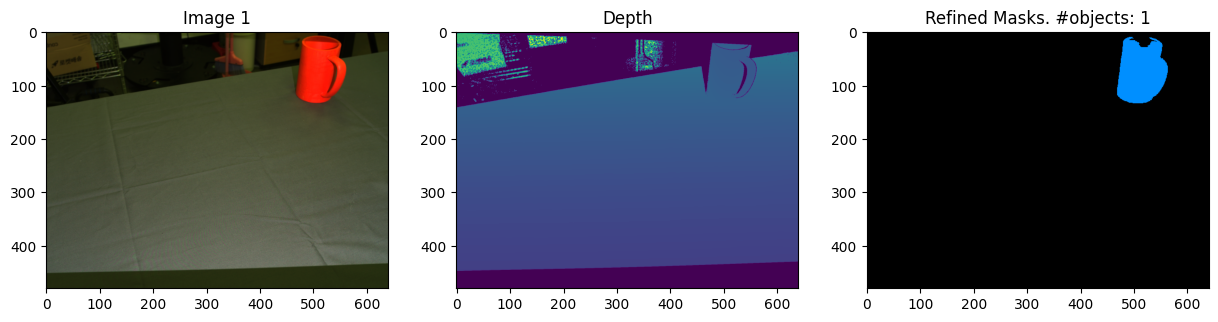

In [54]:
plot_information = plot_informations[0]
util_.subplotter(plot_information[0], titles=plot_information[1], fig_num=1, plot_width=5)

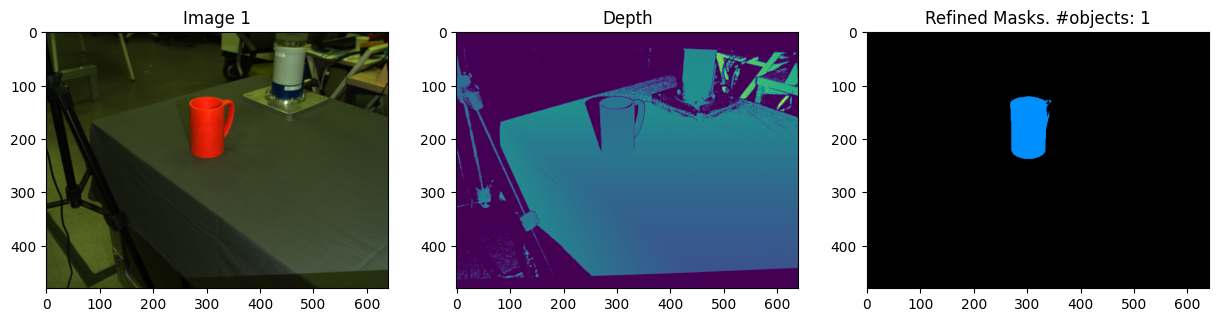

In [55]:
plot_information = plot_informations[1]
util_.subplotter(plot_information[0], titles=plot_information[1], fig_num=1, plot_width=5)

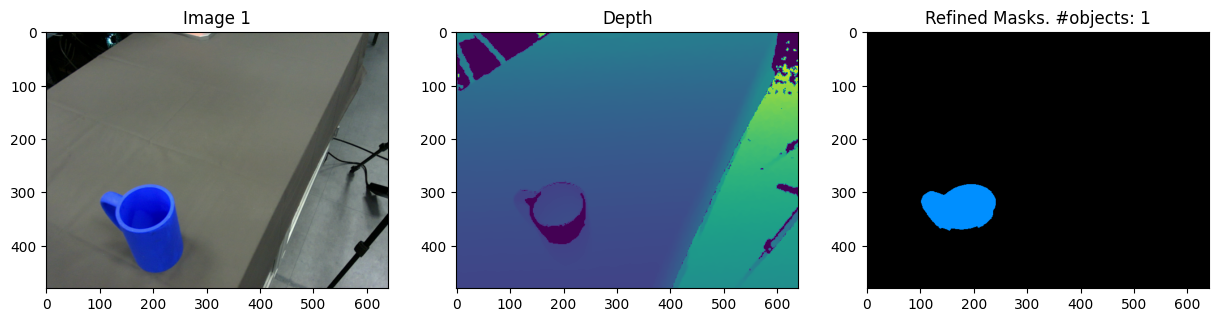

In [56]:
plot_information = plot_informations[2]
util_.subplotter(plot_information[0], titles=plot_information[1], fig_num=1, plot_width=5)

In [57]:
pcds_o3d, frames_o3d = perc.visualize_scene(pcds)
o3d.visualization.draw_geometries(pcds_o3d+frames_o3d)

In [58]:
# est_const = [0.9, 0.004] # waffles
est_const = [0.55, 0.005] # cup

T_obj_world = perc.get_T_world_wrt_object(pcds, est_const,
                            "./assets/cup/cup.obj",get_base= False,   #cup: Base X
                            sample_point_number=1000, max_iter=100)

:: Load two point clouds and disturb initial pose.
PointCloud with 1000 points.
PointCloud with 1000 points.
:: Downsample with a voxel size 0.200.
:: Estimate normal with search radius 0.400.
:: Compute FPFH feature with search radius 1.000.
:: Downsample with a voxel size 0.200.
:: Estimate normal with search radius 0.400.
:: Compute FPFH feature with search radius 1.000.
:: RANSAC registration on downsampled point clouds.
:: Point-to-plane ICP registration is applied on original point
fitness:0.259, rmse:0.0030180838384895594
:: RANSAC registration on downsampled point clouds.
:: Point-to-plane ICP registration is applied on original point
fitness:0.575, rmse:0.002965247682764948
RegistrationResult with fitness=5.750000e-01, inlier_rmse=2.965248e-03, and correspondence_set size of 575
Access transformation to get result.


### Calibration Hand Tuning

In [158]:
pcd_o3ds = []

for i in range (3):
    cam = perc.cams[i]
    rgb, pcd = cam.get_rgb_pcd()
    pcd_w = perc.get_workspace_pcd(pcd, cam)

    pcd_flat = pcd_w.reshape(-1,3)

    tuning_trans =  [[[0.004], [0.002], [0.]],
                     [[0.02], [0.02], [0.012]],
                     [[0.002], [-0.007], [0.01]]]
    tuning_rot = [(-0.008, 0.02, -0.015),(-0.07, -0.04, 0.015),(-0.01, 0., 0.02)]
    tuning_rotm, _ =cv2.Rodrigues(tuning_rot[i])

    align_tuning = np.r_[np.concatenate((tuning_rotm,
                                        tuning_trans[i]),1),
                                        [[0,0,0,1]]]

    bar = np.ones((pcd_flat.shape[0], 1), dtype=np.float32)
    pcd_temp = np.concatenate((pcd_flat,bar),1)

    calib_tuned = np.dot(align_tuning, cam.T_calib)

    pcd_world = np.rot90(np.dot(calib_tuned, np.rot90(pcd_temp,3)), 1)[:,0:3]

    pcd_o3d = to_pointcloud(pcd_world)

    pcd_o3ds.append(pcd_o3d)

    coord = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.1)

o3d.visualization.draw_geometries([pcd_o3ds[0], pcd_o3ds[2], coord])

In [159]:
tuning_trans =  [[[0.004], [0.002], [0.]],
                    [[0.02], [0.02], [0.012]],
                    [[0.002], [-0.007], [0.01]]]
tuning_rot = [(-0.008, 0.02, -0.015),(-0.07, -0.04, 0.015),(-0.01, 0., 0.02)]


tuning_rotmtx = []
for i in range (3):
    tuning_rotm, _ =cv2.Rodrigues(tuning_rot[i])
    tuning_rotmtx.append(tuning_rotm)

In [160]:
# np.save("./config/tuning_trans_config",tuning_trans)
# np.save("./config/tuning_rotmtx_config",tuning_rotmtx)

In [6]:
np.save("./obj_pose_test", T_obj_world)

NameError: name 'T_obj_world' is not defined

In [8]:
T_obj_world = np.load("./obj_pose_test.npy", allow_pickle=True)

In [9]:
T_obj_world

array([[-0.98225881, -0.18732384,  0.00879792, -0.05961406],
       [ 0.18672269, -0.98130098, -0.04672288, -0.30394785],
       [ 0.01738572, -0.04425118,  0.99886915, -0.07233455],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

## ROS Communication

In [10]:
world = SDFWorld()
world.show_in_jupyter()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7007/static/


In [11]:
#robots
gen3s = []
pandas = []
handes = []
panda_hands = []
for i in range(2):
    gen3 = get_predefined_robot(
        world.vis, "gen3+hand_e", f"gen3_{i}", alpha=0.4)
    panda = get_predefined_robot(world.vis, "panda+panda_hand", f"panda_{i}", alpha=0.4)
    hande = Gripper(world.vis, f"hande_{i}", gen3.gripper.model, 
                gen3.gripper.tool_pose_offset,
                max_width=0.05, scale=0.001, alpha=0.5, color='yellow')
    panda_hand = Gripper(world.vis, f"panda_hand_{i}", panda.gripper.model, 
                panda.gripper.tool_pose_offset, is_rev_type=False,
                max_width=0.05, alpha=0.5, color='yellow')
    gen3s.append(gen3)
    pandas.append(panda)
    handes.append(hande)
    panda_hands.append(panda_hand)

In [12]:
#objects and envs

obj_mesh = "./sdf_world/assets/cup/cup_centered.obj"

obj_init = Mesh(world.vis, "obj_init", obj_mesh, color="green", alpha=0.3)
obj_ho = Mesh(world.vis, "obj_ho", obj_mesh, color="yellow", alpha=0.3)
obj_goal = Mesh(world.vis, "obj_goal", obj_mesh, color="red", alpha=0.3)

ground = Box(world.vis, "ground", [0.8,1.8,0.5], 'gray', 0.3)

obstacle_1 = Box(world.vis, "obs1", [0.23, 0.23, 0.55], 'purple', 0.1)
obstacle_2 = Box(world.vis, "obs2", [0.23, 0.23, 0.55], 'purple', 0.1)
obstacle_3 = Box(world.vis, "obs3", [0.23, 0.23, 0.55], 'purple', 0.1)

holder = Box(world.vis, "holder", [0.02, 0.145, 0.336], 'blue', 0.1)

In [13]:
# object init / goal pose
gen3_home_config = np.array([0,0,0,np.pi/2, 0,np.pi/2, 0])
panda_home_config = (panda.arm.model.lb + panda.arm.model.ub)/2

obj_pose_robot_on_base = np.linalg.inv(T_obj_world)+perception_base
obj_pose_init = SE3.from_matrix(obj_pose_robot_on_base)

cup_goal_pose = SE3.from_rotation_and_translation(
    SO3.from_y_radians(-np.pi/2)@SO3.from_x_radians(0.),
    np.array([0.425, 0.95, 0.242]))
#obj_init.set_pose(cup_goal_pose)
obj_goal.set_pose(cup_goal_pose)

In [14]:
yz_offset = 0.1
cup_pre_goal_pose = SE3_trans([0,-yz_offset,yz_offset*np.tan(np.pi*0.126)])@cup_goal_pose
obj_goal.set_pose(cup_pre_goal_pose)

In [15]:
# parameter_dictionary : using perception or predefined parameters
param_dict = dict(
    p0=obj_pose_init.parameters(),
    pg=cup_pre_goal_pose.parameters(),
    r1=gen3_base_pose.parameters(),
    r2=panda_base_pose.parameters(),
    q0_gen3=gen3_home_config,
    q0_panda=panda_home_config,
    p_ho0=np.array([1,0,0,0,0.25,0,0.5])
)

In [16]:
#locate
for gen3 in gen3s:
    gen3.set_base_pose(SE3(param_dict["r1"]))
    gen3.set_joint_angles(param_dict["q0_gen3"])
for panda in pandas:
    panda.set_base_pose(SE3(param_dict["r2"]))
    panda.set_joint_angles(param_dict["q0_panda"])

obj_init.set_pose(SE3(param_dict["p0"]))
obj_ho.set_pose(SE3(param_dict["p_ho0"]))
obj_goal.set_pose(SE3(param_dict["pg"]))

ground.set_pose(SE3_trans([0.17, 0., -0.25]))
obstacle_1.set_pose(SE3_trans([0.67, -0.6, 0.27]))
obstacle_2.set_pose(SE3_trans([0.90, 0.41, 0.27]))
obstacle_3.set_pose(SE3_trans([-0.33, -0.06, 0.27]))
holder.set_pose(SE3_trans([0.4, 1.0, 0.15]))

traj_vis = DottedLine(world.vis, "traj", np.zeros((10,3)),viz_dot=False)
traj_vis.reload(viz_dot=False)

## Define Functions

In [17]:
class PlanningFunctions:
    def __init__(
        self,
        grasp_fn:Callable,
        scale_to_norm:float,
        hand_pc:Array,
        obj_pc:Array,
        env_sdf:SDFContainer,
        hand_sdf:SDFBox,
        fk_ee_fn:Callable,
        robot_pc_fn:Callable,
    ):
        # grasp
        self.grasp_fn = grasp_fn
        self.scale_to_norm = scale_to_norm
        self.hand_pc = hand_pc
        self.obj_pc = obj_pc
        self.env_sdf = env_sdf
        self.hand_sdf = hand_sdf
        self.fk_ee_fn = fk_ee_fn
        self.robot_pc_fn = robot_pc_fn
        self.pre_grasp_pose = SE3_trans([0,0,-0.1])
        #parse
        self.P_grasp = self.get_P_grasp_fn()
        self.grasp_reconst = self.get_grasp_reconst_fn()
        self.grasp_embedding = self.get_grasp_embedding_fn()
        self.R_grasp = self.get_R_grasp_fn()
        self.F_kin2 = self.get_F_kin2_fn()
        self.D_robot = self.get_D_robot_fn()
        self.D_hands = self.get_D_hands_fn()
        self.D_obj = self.get_D_obj_fn()
    
    def get_grasp_embedding_fn(self):
        def grasp_embedding(grasp_point):
            grasp = grasp_point * self.scale_to_norm
            return grasp
        return grasp_embedding
    def get_grasp_reconst_fn(self):
        def grasp_reconst(grasp):
            rot = SO3(self.grasp_fn(grasp)[1:5]).normalize()
            trans = grasp/self.scale_to_norm
            return SE3.from_rotation_and_translation(rot, trans)
        return grasp_reconst
    
    def get_R_grasp_fn(self):
        def R_grasp(grasp:Array, obj_pose:Array):
            # grasp pose reconstruction
            grasp_pose = self.grasp_reconst(grasp)
            depth = self.grasp_fn(grasp)[6] - 0.01
            tool_pose = SE3(obj_pose).normalize() @ grasp_pose @ SE3_trans([0,0,depth])
            return (tool_pose).parameters() 
        return R_grasp
    
    def get_P_grasp_fn(self):
        def P_grasp(grasp):
            return self.grasp_fn(grasp)[0]
        return P_grasp
    
    def get_F_kin2_fn(self):
        def rot_error_vec(rot1, rot2):
            return (rot1.inverse() @ rot2).log()
        def F_kin2(grasp, q1, q2, obj_pose1, obj_pose2, base_pose):
            ee_pose_d1 = SE3(self.R_grasp(grasp, obj_pose1)) @ self.pre_grasp_pose
            ee_pose_d2 = SE3(self.R_grasp(grasp, obj_pose2)) @ self.pre_grasp_pose
            ee_pose1 = SE3(base_pose) @ SE3(self.fk_ee_fn(q1))
            ee_pose2 = SE3(base_pose) @ SE3(self.fk_ee_fn(q2))
            pos_err1 = ee_pose_d1.translation() - ee_pose1.translation()
            pos_err2 = ee_pose_d2.translation() - ee_pose2.translation()
            pos_err = jnp.hstack([pos_err1, pos_err2])

            flip = SO3.from_z_radians(jnp.pi)
            rot_err1 = rot_error_vec(ee_pose1.rotation(), ee_pose_d1.rotation())
            rot_err2 = rot_error_vec(ee_pose2.rotation(), ee_pose_d2.rotation())
            rot_err1_flip = rot_error_vec(ee_pose1.rotation(), ee_pose_d1.rotation()@flip)
            rot_err2_flip = rot_error_vec(ee_pose2.rotation(), ee_pose_d2.rotation()@flip)

            rot_err12 = jnp.hstack([rot_err1, rot_err2])
            rot_err12_flip = jnp.hstack([rot_err1_flip, rot_err2_flip])
            rot_err12_mag = jnp.sum(rot_err12**2)
            rot_err12_mag_flip = jnp.sum(rot_err12_flip**2)

            rot_err = jnp.where(rot_err12_mag < rot_err12_mag_flip,
                                rot_err12, rot_err12_flip)
            return jnp.hstack([pos_err, 0.3*rot_err])
        return F_kin2
    def get_D_robot_fn(self):
        def D_robot(q:Array):
            assigned_pc = self.robot_pc_fn(q)
            return self.env_sdf.distances(assigned_pc).min()
        return D_robot
    def get_D_hands_fn(self):
        def D_hands(grasp1, grasp2):
            grasp_pose1 = self.grasp_reconst(grasp1)
            grasp_pose2 = self.grasp_reconst(grasp2)
            grasp1_wrt_2 = grasp_pose1.inverse() @ grasp_pose2
            points = jax.vmap(grasp1_wrt_2.apply)(self.hand_pc)
            return jax.vmap(self.hand_sdf.sdf)(points).min()
        return D_hands
    def get_D_hand_fn(self):
        def D_hand(grasp, obj_pose):
            tool_pose = self.R_grasp(grasp, obj_pose)
            assigned_pc = jax.vmap(SE3(tool_pose).apply)(self.hand_pc)
            return self.env_sdf.distances(assigned_pc).min()
        return D_hand
    def get_D_obj_fn(self):
        def D_obj(q:Array, grasp:Array):
            ee_pose = SE3(self.fk_ee_fn(q))
            grasp_pose = self.grasp_reconst(grasp)
            obj_pose = ee_pose @ grasp_pose.inverse()
            pc = jax.vmap(obj_pose.apply)(self.obj_pc)
            return self.env_sdf.distances(pc).min()
        return D_obj
    def get_smooth_trajectory_fn(self):
        def smooth_traj(*qs):
            qs = jnp.vstack(qs)
            qdiffs = qs[1:] - qs[:-1]
            return jnp.sum(qdiffs**2)
        return smooth_traj
    def get_orn_regulation_fn(self):
        def orn_reg(pose, g1, g2):
            orn = pose[:4]
            pose = SE3.from_rotation(SO3(orn).normalize())
            tool_pose1 = pose @ self.grasp_reconst(g1)
            tool_pose2 = pose @ self.grasp_reconst(g2)
            y = tool_pose1.translation()[1] - tool_pose2.translation()[1]
            grasp_center = (tool_pose1.translation() + tool_pose2.translation())/2
            ref_point = np.array([0.25, 0, 0.5])
            return (y + jnp.linalg.norm(grasp_center-ref_point))
        return orn_reg

In [18]:
grasp_fn, scale_to_norm = \
    load_grasp_fn_scale("model/grasp_net_cup", out_dim=7)
env_sdf = SDFContainer([ground, obstacle_1, obstacle_2, obstacle_3, holder])

hidden_dim:32, out_dim:7


In [19]:
gen3_pl_fns = PlanningFunctions(
    grasp_fn=grasp_fn,
    scale_to_norm=scale_to_norm,
    hand_pc=hande.get_hand_pc_wrt_tool_pose(),
    obj_pc=farthest_point_sampling(obj_init.mesh.sample(100), 10),
    env_sdf=env_sdf,
    hand_sdf=hande.get_bounding_box("hand_bb_gen3", visualize=False),
    fk_ee_fn=gen3.get_fk_ee_fn(),
    robot_pc_fn=gen3.get_robot_pc_fn()
)
panda_pl_fns = PlanningFunctions(
    grasp_fn=grasp_fn,
    scale_to_norm=scale_to_norm,
    hand_pc=panda_hand.get_hand_pc_wrt_tool_pose(),
    obj_pc=farthest_point_sampling(obj_init.mesh.sample(100), 10),
    env_sdf=env_sdf,
    hand_sdf=panda_hand.get_bounding_box("hand_bb_panda", visualize=False),
    fk_ee_fn=panda.get_fk_ee_fn(),
    robot_pc_fn=panda.get_robot_pc_fn()
)

def D_hands(grasp1, grasp2):
    grasp_pose1 = gen3_pl_fns.grasp_reconst(grasp1)
    grasp_pose2 = panda_pl_fns.grasp_reconst(grasp2)
    grasp1_wrt_2 = grasp_pose1.inverse() @ grasp_pose2
    points = jax.vmap(grasp1_wrt_2.apply)(gen3_pl_fns.hand_pc)
    return jax.vmap(panda_pl_fns.hand_sdf.sdf)(points).min()

In [20]:
# Optimization Problem: Single-arm Reorientation
Variable.init()
Parameter.init()
Constraint.init()
Objective.init()

p0 = Parameter("p0", param_dict["p0"])
pg = Parameter("pg", param_dict["pg"])
r1 = Parameter("r1", param_dict["r1"])
r2 = Parameter("r2", param_dict["r2"])
q0_gen3 = Parameter("q0_gen3", param_dict["q0_gen3"])
q0_panda = Parameter("q0_panda", param_dict["q0_panda"])

g1 = Grasp()
g2 = Grasp()
p1 = HoPose()

# config at kinematic switch
q1 = Config(gen3_home_config, gen3.arm.model.lb, gen3.arm.model.ub)
q2 = Config(gen3_home_config, gen3.arm.model.lb, gen3.arm.model.ub)
q3 = Config(panda_home_config, panda.arm.model.lb, panda.arm.model.ub)
q4 = Config(panda_home_config, panda.arm.model.lb, panda.arm.model.ub)

#left traj
q01_0 = ViaConfig(gen3_home_config, gen3.arm.model.lb, gen3.arm.model.ub)
q01_1 = ViaConfig(gen3_home_config, gen3.arm.model.lb, gen3.arm.model.ub)
q12_0 = ViaConfig(gen3_home_config, gen3.arm.model.lb, gen3.arm.model.ub)
q12_1 = ViaConfig(gen3_home_config, gen3.arm.model.lb, gen3.arm.model.ub)
q20_0 = ViaConfig(gen3_home_config, gen3.arm.model.lb, gen3.arm.model.ub)
q20_1 = ViaConfig(gen3_home_config, gen3.arm.model.lb, gen3.arm.model.ub)
#right traj
q03_0 = ViaConfig(panda_home_config, panda.arm.model.lb, panda.arm.model.ub)
q03_1 = ViaConfig(panda_home_config, panda.arm.model.lb, panda.arm.model.ub)
q34_0 = ViaConfig(panda_home_config, panda.arm.model.lb, panda.arm.model.ub)
q34_1 = ViaConfig(panda_home_config, panda.arm.model.lb, panda.arm.model.ub)
q40_0 = ViaConfig(panda_home_config, panda.arm.model.lb, panda.arm.model.ub)
q40_1 = ViaConfig(panda_home_config, panda.arm.model.lb, panda.arm.model.ub)

viaconfigs_gen3 = [q01_0, q01_1, q12_0, q12_1, q20_0, q20_1]
viaconfigs_panda = [q03_0, q03_1, q34_0, q34_1, q40_0, q40_1]
#objective
Objective.add_fn("SmoothTrajectory", panda_pl_fns.get_smooth_trajectory_fn())
Objective.add_fn("OrnRegulation", panda_pl_fns.get_orn_regulation_fn())
traj_l = [q0_gen3, q01_0, q01_1, q1, q12_0, q12_1, q2, q20_0, q20_1, q0_gen3] #, , 
traj_r = [q0_panda, q03_0, q03_1, q3, q34_0, q34_1, q4, q40_0, q40_1, q0_panda] # 

obj = []
obj.append(SmoothTrajectory("traj_l", traj_l))
obj.append(SmoothTrajectory("traj_r", traj_r))
obj.append(OrnRegulation("orn_reg_p1", p1, g1, g2))
# beta = jnp.array([1, 0.01])

# constraints
Constraint.add_fn("GraspProb", gen3_pl_fns.get_P_grasp_fn())
Constraint.add_fn("Kin2_gen3", gen3_pl_fns.get_F_kin2_fn())
Constraint.add_fn("Kin2_panda", panda_pl_fns.get_F_kin2_fn())
Constraint.add_fn("ColConfig_gen3", gen3_pl_fns.get_D_robot_fn())
Constraint.add_fn("ColConfig_panda", panda_pl_fns.get_D_robot_fn())
Constraint.add_fn("ColHands", D_hands)
Constraint.add_fn("ColHand_gen3", gen3_pl_fns.get_D_hand_fn())
Constraint.add_fn("ColHand_panda", panda_pl_fns.get_D_hand_fn())
#Constraint.add_fn("ColObject", D_obj)

consts = []
consts.append(GraspProb([g1], logit_limit=0.5))
consts.append(GraspProb([g2], logit_limit=0.5))
consts.append(Kin2([g1, q1, q2, p0, p1, r1], "Kin2_gen3"))
consts.append(Kin2([g2, q3, q4, p1, pg, r2], "Kin2_panda"))
consts.append(ColConfig([q1], safe_dist=0.08, fn_name="ColConfig_gen3"))
consts.append(ColConfig([q2], safe_dist=0.08, fn_name="ColConfig_gen3"))
consts.append(ColConfig([q3], safe_dist=0.08, fn_name="ColConfig_panda"))
consts.append(ColConfig([q4], safe_dist=0.08, fn_name="ColConfig_panda"))
for var in viaconfigs_gen3:
    consts.append(ColConfig([var], safe_dist=0.08, fn_name="ColConfig_gen3"))
for var in viaconfigs_panda:
    consts.append(ColConfig([var], safe_dist=0.08, fn_name="ColConfig_panda"))
consts.append(ColHands([g1, g2], "ColHands"))
consts.append(ColHand([g1, p0], safe_dist=0.01, fn_name="ColHand_gen3"))
consts.append(ColHand([g2, pg], safe_dist=0.01, fn_name="ColHand_panda"))
# c6 = ColObject([q12_0, g1])
# c7 = ColObject([q12_1, g1])
# alpha = np.array([1, 0.001, 1, 1., 1.])
#alpha = np.array([1.])

In [21]:
class OptProb:
    def __init__(self, obj_fn, constr_fn, param_dict,
                 alpha, beta,
                 debug=False, compile=False):
        self.obj_fn = obj_fn
        self.constr_fn = constr_fn
        self.debug = debug
        self.grads = {}
        self.jacs = {}
        self.vg_obj_fn = jax.value_and_grad(self.obj_fn, argnums=1)
        self.vj_constr_fn = value_and_jacfwd(self.constr_fn, argnums=1)
        self.param = Parameter.to_vec(param_dict)
        self.alpha = alpha
        self.beta = beta
        self.jac_struct = Constraint.get_jacobian_structure()
        if compile:
            self.vg_obj_fn = jax.jit(self.vg_obj_fn)
            self.vj_constr_fn = jax.jit(self.vj_constr_fn)
            x_dummy = Variable.get_init_value()
            self.vg_obj_fn(self.param, x_dummy, self.beta)
            self.vj_constr_fn(self.param, x_dummy, self.alpha)
        self.iter_ends = False
        self.x_history = []
    
    def set_alpha(self, alpha):
        self.alpha = alpha # array
    def set_beta(self, beta):
        self.beta = beta #scalar
    
    def hash(self, x):
        return hash(x.tobytes())
    def objective(self, x):
        if self.debug and self.iter_ends:
            self.x_history.append(x)
            self.iter_ends = False
        value, grad = self.vg_obj_fn(self.param, x, self.beta)
        key = self.hash(x)
        self.grads[key] = grad
        return value
    def gradient(self, x):
        key = self.hash(x)
        if key in self.grads:
            return self.grads[key]
        _, grad = self.vg_obj_fn(self.param, x, self.beta)
        return grad
    def constraints(self, x):
        #return self.constr_fn(self.param, x, self.alpha)
        value, jac = self.vj_constr_fn(self.param, x, self.alpha)
        key = self.hash(x)
        self.jacs[key] = jac
        return value
    def jacobian(self, x):
        #return self.jac_fn(self.param, x, self.alpha)
        key = self.hash(x)
        if key not in self.jacs:
            _, jac = self.vj_constr_fn(self.param, x, self.alpha)
        else: jac = self.jacs[key]
        return jac[self.jac_struct]
    def jacobianstructure(self):
        return self.jac_struct
    def intermediate(self, *args):
        self.iter_ends=True

In [22]:
def get_grasp(q:Array, obj_pose:Array, base_pose:Array, pl_fns):
    tcp = SE3(base_pose).apply(pl_fns.fk_ee_fn(q)[-3:])
    tcp_wrt_obj = SE3(obj_pose).inverse().apply(tcp)
    grasp = pl_fns.grasp_embedding(tcp_wrt_obj)
    return grasp

In [23]:
obj_fn = Objective.get_obj_fn()  #lambda beta, param, x: 0.
constr_fn = Constraint.get_constr_fn()
prob = OptProb(obj_fn, constr_fn, param_dict,
               alpha=1., beta=1., debug=True, compile=True)

In [24]:
prob.param = Parameter.to_vec(param_dict)
ipopt = cyipopt.Problem(
    n=Variable.vdim(), 
    m=Constraint.cdim(), 
    problem_obj=prob,
    lb=Variable.limit("lower"), ub=Variable.limit("upper"),
    cl=Constraint.limit("lower"), cu=Constraint.limit("upper"),
)
ipopt.add_option("acceptable_iter", 5)
ipopt.add_option("nlp_scaling_method", "gradient-based")
ipopt.add_option("acceptable_tol", np.inf) #release
ipopt.add_option("acceptable_dual_inf_tol", np.inf) #release
ipopt.add_option("acceptable_constr_viol_tol", 0.1)
ipopt.add_option("acceptable_obj_change_tol", 10.)
ipopt.add_option('mu_strategy', 'adaptive')
ipopt.add_option('max_iter', 1000)

In [25]:
prob.alpha = 0.001
prob.beta = 0.02

x0 = Variable.get_init_value()
x0[:3] = get_grasp(gen3_home_config, param_dict["p0"], param_dict["r1"], gen3_pl_fns)
x0[3:6] = get_grasp(panda_home_config, param_dict["p_ho0"], param_dict["r2"], panda_pl_fns)
prob.x_history = []
ipopt.add_option("print_level", 5)
sol, info = ipopt.solve(Variable.get_init_value())
info['status']


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.12, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:      576
Number of nonzeros in inequality constraint Jacobian.:      130
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      125
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      125
                     variables with only upper bounds:        0
Total number of equality constraints.................:       24
Total number of inequality c

1


Number of Iterations....: 212

                                   (scaled)                 (unscaled)
Objective...............:   6.6805200576782227e+00    6.6805200576782227e+00
Dual infeasibility......:   6.2440997597868302e+00    6.2440997597868302e+00
Constraint violation....:   8.0195228235879767e-09    8.0195228235879767e-09
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.6171898350418008e-04    3.6171898350418008e-04
Overall NLP error.......:   1.9523290376983147e+00    6.2440997597868302e+00


Number of objective function evaluations             = 566
Number of objective gradient evaluations             = 213
Number of equality constraint evaluations            = 566
Number of inequality constraint evaluations          = 566
Number of equality constraint Jacobian evaluations   = 213
Number of inequality constraint Jacobian evaluations = 213
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT

In [26]:
def debug_fn(x):
    inst_dict = {**param_dict, 
                **Variable.to_var_dict(x)}

    gen3s[0].set_joint_angles(inst_dict["config0"])
    gen3s[1].set_joint_angles(inst_dict["config1"])    
    pandas[0].set_joint_angles(inst_dict["config2"])
    pandas[1].set_joint_angles(inst_dict["config3"])  
    obj_ho.set_pose(SE3(inst_dict["hopose0"]))
    handes[0].set_tool_pose(SE3(gen3_pl_fns.R_grasp(inst_dict["grasp0"], inst_dict["p0"])))
    handes[1].set_tool_pose(SE3(gen3_pl_fns.R_grasp(inst_dict["grasp0"], inst_dict["hopose0"])))
    panda_hands[0].set_tool_pose(SE3(panda_pl_fns.R_grasp(inst_dict["grasp1"], inst_dict["hopose0"])))
    panda_hands[1].set_tool_pose(SE3(panda_pl_fns.R_grasp(inst_dict["grasp1"], inst_dict["pg"])))


In [27]:
def constr_check(x, is_val=False):
    tol = 0.01
    cval = prob.constraints(x)
    if is_val:
        return Constraint.to_constr_dict(cval)
    check = (-tol+Constraint.limit("lower") < cval) & (cval < Constraint.limit("upper")+tol)
    for name, values in Constraint.to_constr_dict(check).items():
        print(name, values)

In [35]:
debug_fn(sol)
constr_check(sol)

GraspProb0 [ True]
GraspProb1 [ True]
Kin2_gen30 [ True  True  True  True  True  True  True  True  True  True  True  True]
Kin2_panda0 [ True  True  True  True  True  True  True  True  True  True  True  True]
ColConfig_gen30 [ True]
ColConfig_gen31 [ True]
ColConfig_gen32 [ True]
ColConfig_gen33 [ True]
ColConfig_gen34 [ True]
ColConfig_gen35 [ True]
ColConfig_gen36 [ True]
ColConfig_gen37 [ True]
ColConfig_panda0 [ True]
ColConfig_panda1 [ True]
ColConfig_panda2 [ True]
ColConfig_panda3 [ True]
ColConfig_panda4 [ True]
ColConfig_panda5 [ True]
ColConfig_panda6 [ True]
ColConfig_panda7 [ True]
ColHands0 [ True]
ColHand_gen30 [ True]
ColHand_panda0 [ True]


In [53]:
#refine solution
ipopt.add_option("print_level", 1)
ipopt.add_option("acceptable_dual_inf_tol", 0.1)
ipopt.add_option("acceptable_constr_viol_tol", 0.1)
sol, info = ipopt.solve(sol)
info['status']

-1

In [36]:
ik_fn = get_ik_fn()
def gen3_inverse_kinematics(
        target_pose:SE3, robot_base_pose:SE3, q_init=gen3_home_config, fk_ee_fn=gen3_pl_fns.fk_ee_fn):
    config = IKConfig(
        jax.tree_util.Partial(fk_ee_fn), 
        robot_base_pose, 
        0.0001, 
        0.1, 
        30)
    init_val = (q_init, target_pose, np.inf, 0, config)
    result = ik_fn(init_val=init_val)
    print(f"iter:{result[3]}, error:{result[2]}")
    return result[0]

def panda_inverse_kinematics(
        target_pose:SE3, robot_base_pose:SE3, q_init=panda_home_config, fk_ee_fn=panda_pl_fns.fk_ee_fn):
    config = IKConfig(
        jax.tree_util.Partial(fk_ee_fn), 
        robot_base_pose, 
        0.0001, 
        0.1, 
        30)
    init_val = (q_init, target_pose, np.inf, 0, config)
    result = ik_fn(init_val=init_val)
    print(f"iter:{result[3]}, error:{result[2]}")
    return result[0]

In [37]:
from scipy.interpolate import CubicSpline
class Action:
    is_rt_sim:bool = False
    sol:Dict[str,np.ndarray] = {}
    def __init__(self, variables):
        self.variables: List[Variable] = variables
        self.values = {}
    def set_trajectory(self, duration):
        raise NotImplementedError("not implemented")
    def get_q(self, t):
        raise NotImplementedError("not implemented")
    def parse_values(self):
        for var in self.variables:
            self.values[var.name] = self.sol[var.name]

class Move(Action):
    def __init__(self, waypoints:List[Union[Parameter,Variable]]):
        super().__init__(waypoints)
        # self.waypoints:List[Union[Parameter,Variable]] = waypoints
        #self.variables = waypoints  
        self.qnames = [config.name for config in waypoints]      
        self.parse_values()
    
    @staticmethod
    def cubic_spline_7dof(qs, last_time):
        tt = np.linspace(0, last_time, len(qs), endpoint=True)
        cs = [CubicSpline(tt, qs[:,i], bc_type='clamped') for i in range(7)]
        return cs

    def set_trajectory(self, duration):
        self.qs = np.vstack([self.values[name] for name in self.qnames])
        self.cs = Move.cubic_spline_7dof(self.qs, duration) #cubic spline object
    
    def get_q(self, t):
        return np.asarray([cs(t) for cs in self.cs])
    

class MoveFree(Move):
    def __init__(self, waypoints):
        super().__init__(waypoints)

class MoveHold(Move):
    def __init__(self, waypoints, grasp):
        super().__init__(waypoints)
        self.grasp = grasp

class KinSwitch(Action):
    grasp_force = 10.
    def __init__(self, variables):
        super().__init__(variables)
    # def grip(self, robot:Gen3, width):
    #     if self.is_rt_sim:
    #         robot.grip(width, self.grasp_force)
    #     else:
    #         robot.set_gripper_width(width)

class PickPlace(KinSwitch):
    def __init__(self, grasp, obj_pose, q_pre, robot_base, type, R_grasp, ik_fn):
        variables = [grasp, obj_pose, q_pre, robot_base]
        super().__init__(variables)
        self.parse_values()
        self.grasp = grasp
        self.obj_pose = obj_pose
        self.q_pre = q_pre
        self.robot_base = robot_base
        self.type = type
        self.R_grasp = R_grasp
        self.ik_fn = ik_fn
    
    def set_trajectory(self, duration, approach_time=2.):
        self.duration = duration
        self.approach_time = approach_time
        self.kin_switch_time = self.duration - self.approach_time*2
        print(self.duration)
        print(self.approach_time)
        print(self.kin_switch_time)
        assert self.kin_switch_time > 0.

        self.grasp_pose = SE3(self.R_grasp(
            self.values[self.grasp.name], self.values[self.obj_pose.name]))
        self.robot_base_pose = SE3(self.values[self.robot_base.name])
        self.q_pre_value = self.values[self.q_pre.name]
        self.q_hold_value = self.ik_fn(
            target_pose=self.grasp_pose, 
            robot_base_pose=self.robot_base_pose, 
            q_init=self.q_pre_value)
        self.cs_pre_to_grasp = Move.cubic_spline_7dof(
            np.vstack([self.q_pre_value, self.q_hold_value]), approach_time)
        if self.type == "drop":
            depth = 0.08
            self.drop_pose = SE3_trans([0, depth, -np.tan(np.pi/6)*depth]) @ self.grasp_pose
            self.q_drop_value = self.ik_fn(
                target_pose=self.drop_pose, 
                robot_base_pose=self.robot_base_pose, 
                q_init=self.q_hold_value)
            self.cs_grasp_to_drop = Move.cubic_spline_7dof(
                np.vstack([self.q_hold_value, self.q_drop_value]), self.kin_switch_time/3)

    def get_q(self, t):
        if 0. <= t < self.approach_time:
            q = np.asarray([cs(t) for cs in self.cs_pre_to_grasp]) #go to grasp
        elif self.approach_time <= t < self.approach_time+self.kin_switch_time: #self.duration*2/3:
            if self.type in ["pick", "hold"]:
                # self.grip(gen3_l, 0.00)
                q = self.q_hold_value
            elif self.type == "drop":
                drop_start = self.approach_time
                drop_end = self.approach_time + self.kin_switch_time
                if drop_start <= t < drop_start + self.kin_switch_time/3:
                    t = t - drop_start
                    q = np.asarray([cs(t) for cs in self.cs_grasp_to_drop])
                elif drop_start + self.kin_switch_time/3 <= t < drop_start + self.kin_switch_time*2/3:
                    # self.grip(gen3_r, 0.05)
                    q = self.q_drop_value
                else:
                    t = self.approach_time+self.kin_switch_time - t
                    q = np.asarray([cs(t) for cs in self.cs_grasp_to_drop])
            elif self.type in ["place"]:
                raise NotImplementedError("Not implemented")
        else:
            t = self.duration - t
            q = np.asarray([cs(t) for cs in self.cs_pre_to_grasp]) #go to pre
        return q

class Handover(KinSwitch):
    def __init__(self, grasp1, grasp2, ho_pose, q_pre1, q_pre2, robot_base1, robot_base2,
                 R_grasp_l, ik_fn_l, R_grasp_r, ik_fn_r):
        variables = [grasp1, grasp2, q_pre1, q_pre2, ho_pose, robot_base1, robot_base2]
        super().__init__(variables)
        self.parse_values()
        self.grasp1 = grasp1
        self.grasp2 = grasp2
        self.q_pre1 = q_pre1
        self.q_pre2 = q_pre2
        self.ho_pose = ho_pose
        self.robot_base1 = robot_base1
        self.R_grasp_l = R_grasp_l
        self.ik_fn_l = ik_fn_l
        self.R_grasp_r = R_grasp_r
        self.ik_fn_r = ik_fn_r
        
        self.robot_base2 = robot_base2
    def set_trajectory(self, duration):
        self.grasp_pose1 = SE3(self.R_grasp_l(self.values[self.grasp1.name], self.values[self.ho_pose.name]))
        self.robot_base_pose1 = SE3(self.values[self.robot_base1.name])
        self.q_pre1_value = self.values[self.q_pre1.name]
        self.q_hold1_value = self.ik_fn_l(
            target_pose=self.grasp_pose1, 
            robot_base_pose=self.robot_base_pose1, 
            q_init=self.q_pre1_value)
        
        self.grasp_pose2 = SE3(self.R_grasp_r(self.values[self.grasp2.name], self.values[self.ho_pose.name]))
        self.robot_base_pose2 = SE3(self.values[self.robot_base2.name])
        self.q_pre2_value = self.values[self.q_pre2.name]
        self.q_hold2_value = self.ik_fn_r(
            target_pose=self.grasp_pose2, 
            robot_base_pose=self.robot_base_pose2, 
            q_init=self.q_pre2_value)
        
        self.cs_pre1_to_grasp1 = Move.cubic_spline_7dof(
            np.vstack([self.q_pre1_value, self.q_hold1_value]), duration/6)
        self.cs_pre2_to_grasp2 = Move.cubic_spline_7dof(
            np.vstack([self.q_pre2_value, self.q_hold2_value]), duration/6)
        self.duration = duration
    
    def get_q(self, t):
        if 0. <= t < self.duration/6:
            q_l = np.asarray([cs(t) for cs in self.cs_pre1_to_grasp1]) #go to grasp1
            q_r = self.q_pre2_value
        elif self.duration/6 <= t < self.duration*2/6:
            t = t - self.duration/6
            q_l = self.q_hold1_value
            q_r = np.asarray([cs(t) for cs in self.cs_pre2_to_grasp2])
        elif self.duration*2/6 <= t < self.duration*3/6:
            q_l = self.q_hold1_value
            q_r = self.q_hold2_value
            #self.grip(gen3_r, 0.00)
        elif self.duration*3/6 <= t < self.duration*4/6:
            q_l = self.q_hold1_value
            q_r = self.q_hold2_value
            #self.grip(gen3_l, 0.05)
        elif self.duration*4/6 <= t < self.duration*5/6:
            t = self.duration*5/6 - t
            q_l = np.asarray([cs(t) for cs in self.cs_pre1_to_grasp1]) #go to grasp1
            q_r = self.q_hold2_value
        else:
            t = self.duration - t
            q_l = self.q_pre1_value
            q_r = np.asarray([cs(t) for cs in self.cs_pre2_to_grasp2]) #go to grasp1
        return q_l, q_r

class DoNothing(Action):
    def __init__(self, config):
        self.config = config
    def set_trajectory(self, duration):
        self.q = self.sol[self.config.name]
    def get_q(self, t):
        return self.q

class DualAction:
    def __init__(self, action_pair, duration, approach_time=2.):
        self.duration = duration
        self.approach_time = approach_time
        self.action_lr:Action = None
        self.action_l:Action = None
        self.action_r:Action = None
        if isinstance(action_pair, Handover):
            self.action_lr = action_pair
        else:
            self.action_l = action_pair[0]
            self.action_r = action_pair[1]
        self.set_trajectory()
        
    def set_trajectory(self):
        if self.action_lr is None:
            for action in [self.action_l, self.action_r]:
                if isinstance(action, PickPlace):
                    action.set_trajectory(self.duration, self.approach_time)
                else:
                    action.set_trajectory(self.duration)
        else:
            self.action_lr.set_trajectory(self.duration)
    
    def get_qs(self, t):
        if self.action_lr is None:
            q_l = self.action_l.get_q(t)
            q_r = self.action_r.get_q(t)
        else:
            q_l, q_r = self.action_lr.get_q(t)
        return q_l, q_r

In [38]:
Action.sol = {**Variable.to_var_dict(sol), **Parameter.get_param_dict()}

In [39]:
#initialize
actions = [
    DualAction([MoveFree([q0_gen3, q01_0, q01_1, q1]), 
                DoNothing(q0_panda)], 5.), 
    DualAction([PickPlace(g1, p0, q1, r1, "pick", gen3_pl_fns.R_grasp, gen3_inverse_kinematics), 
                DoNothing(q0_panda)], 6., approach_time=2.), 
    DualAction([MoveHold([q1, q12_0, q12_1, q2], g1), 
                MoveFree([q0_panda, q03_0, q03_1, q3])], 6.), 
    DualAction(Handover(g1, g2, p1, q2, q3, r1, r2, 
                        gen3_pl_fns.R_grasp, gen3_inverse_kinematics,
                        panda_pl_fns.R_grasp, panda_inverse_kinematics), 6.),
    DualAction([MoveFree([q2, q20_0, q20_1, q0_gen3]), 
                MoveHold([q3, q34_0, q34_1, q4], g2)], 6.),
    DualAction([DoNothing(q0_gen3), 
                PickPlace(g2, pg, q4, r2, "drop", panda_pl_fns.R_grasp, panda_inverse_kinematics)], 10.), 
    DualAction([DoNothing(q0_gen3), MoveFree([q4, q40_0, q40_1, q0_panda])], 4),
]

6.0
2.0
2.0
iter:31, error:0.006033760495483875
iter:27, error:8.270162652479485e-05
iter:21, error:9.114243584917858e-05
10.0
2.0
6.0
iter:29, error:8.10651617939584e-05
iter:31, error:9.418140689376742e-05


In [40]:
dt = 0.2
dual_action = actions[2]
for t in np.arange(0, dual_action.duration, dt):
    q_l, q_r = dual_action.get_qs(t)
    gen3s[0].set_joint_angles(q_l)
    pandas[0].set_joint_angles(q_r)
    time.sleep(0.1)

def traj_to_msg(qs):
    traj = [qs[i] for i in range(4)]
    return traj

In [41]:
msg1 = kinova.generate_traj_msg(traj_to_msg(actions[0].action_l.qs), vel=0.3)

msg2_1 = kinova.generate_traj_msg([actions[1].action_l.q_pre_value, actions[1].action_l.q_hold_value], vel=0.2)
msg2_2 = kinova.generate_traj_msg([actions[1].action_l.q_hold_value, actions[1].action_l.q_pre_value], vel=0.2)

msg3_1 = kinova.generate_traj_msg(traj_to_msg(actions[2].action_l.qs), vel=0.5)
msg3_2 = franka.generate_traj_msg(traj_to_msg(actions[2].action_r.qs), vel=0.2)

msg4_1 = kinova.generate_traj_msg([actions[3].action_lr.q_pre1_value, actions[3].action_lr.q_hold1_value], vel=0.2)
msg4_2 = franka.generate_traj_msg([actions[3].action_lr.q_pre2_value, actions[3].action_lr.q_hold2_value], vel=0.2)

msg4_3 = kinova.generate_traj_msg([actions[3].action_lr.q_hold1_value, actions[3].action_lr.q_pre1_value], vel=0.2)
msg4_4 = franka.generate_traj_msg([actions[3].action_lr.q_hold2_value, actions[3].action_lr.q_pre2_value], vel=0.2)

msg5_1 = kinova.generate_traj_msg(traj_to_msg(actions[4].action_l.qs), vel=0.3)
msg5_2 = franka.generate_traj_msg(traj_to_msg(actions[4].action_r.qs), vel=0.25)


# 6. fra -> drop
msg6_1 = franka.generate_traj_msg([actions[5].action_r.q_pre_value, actions[5].action_r.q_hold_value], vel=0.15)
msg6_2 = franka.generate_traj_msg([actions[5].action_r.q_hold_value, actions[5].action_r.q_drop_value], vel=0.1)
msg6_3 = franka.generate_traj_msg([actions[5].action_r.q_drop_value, actions[5].action_r.q_pre_value], vel=0.15)

# 7. fra -> home
msg7 = franka.generate_traj_msg(traj_to_msg(actions[6].action_r.qs), vel=0.3)

last_timestep:  7.8122835430197615
last_timestep:  4.020962119102478
last_timestep:  4.020962119102478
last_timestep:  4.084206243034301
last timestep: 3.622808850667515
last_timestep:  1.740041971206665
last timestep: 1.8248185438439801
last_timestep:  1.740041971206665
last timestep: 1.8248185438439801
last_timestep:  4.8789648559457435
last timestep: 6.725990212794304
last timestep: 2.0871936773591035
last timestep: 2.175814390182495
last timestep: 2.0420253012971585
last timestep: 4.928436244470076


In [113]:
franka.grip(width=0.09)

In [115]:
kinova.grip(width=0.05)

In [47]:
# Kinova PID Controller Gain
# robot.set_ctrl_gain("kp", [50, 50, 50, 50, 50, 50, 50])
# robot.set_ctrl_gain("ki", [625,700,625,625,625,625,625])
kinova.set_ctrl_gain("gamma", [0.2,0.2,0.2,0.2,0.25,0.25,0.25])

kinova.set_pos_ctrl_mode('gravity')

In [49]:
msg = kinova.generate_traj_msg([kinova.q_curr, gen3_home_config], vel=0.2)
kinova.set_waypoints(msg)

last_timestep:  13.63178249206601


In [44]:
msg = franka.generate_traj_msg([franka.q, panda_home_config], vel=0.3)
franka.publish_traj_msg(msg)

last timestep: 4.918855494360375


In [ ]:
kinova.set_waypoints(msg1)

# Robot Execution (!Warning)

In [46]:

kinova.set_waypoints(msg1)
time.sleep(5) #TODO time for traj

In [203]:
kinova.set_pos_ctrl_mode('gravity')

In [48]:
kinova.set_waypoints(msg2_1)

In [218]:
kinova.set_pos_ctrl_mode('gravity')

In [220]:
kinova.grip(width=0.0)

In [221]:
kinova.set_waypoints(msg2_2)

In [222]:
kinova.set_pos_ctrl_mode('gravity')

In [223]:
kinova.set_waypoints(msg3_1)
franka.publish_traj_msg(msg3_2)

In [224]:
kinova.set_pos_ctrl_mode('gravity')

In [225]:
kinova.set_waypoints(msg4_1)

In [226]:
kinova.set_pos_ctrl_mode('gravity')

In [227]:
franka.publish_traj_msg(msg4_2)

In [228]:
franka.grip(width=0.015, force=70) #TODO grasp width of cup handle


In [229]:
kinova.grip(width=0.05)

In [230]:
kinova.set_waypoints(msg4_3)

In [234]:
kinova.set_pos_ctrl_mode('gravity')

In [235]:
franka.publish_traj_msg(msg4_4)

In [233]:
kinova.set_waypoints(msg5_1)
franka.publish_traj_msg(msg5_2)


In [236]:
franka.publish_traj_msg(msg6_1)

In [134]:
franka.publish_traj_msg(msg6_2)

In [143]:
franka.grip(width=0.09)

In [136]:
franka.publish_traj_msg(msg6_3)

In [137]:
franka.publish_traj_msg(msg7)

In [ ]:
# 1. kin -> pre_grasp
msg1 = kinova.generate_traj_msg(traj_to_msg(actions[0].action_l.qs), vel=0.3)
kinova.set_waypoints(msg1)
time.sleep(5) #TODO time for traj


# 2. kin -> grasp
msg2_1 = kinova.generate_traj_msg([kinova.q_curr, actions[1].action_l.q_hold_value], vel=0.3)
kinova.set_waypoints(msg2_1)

kinova.grip(width=0.05) #TODO grasp width of cup handle

msg2_2 = kinova.generate_traj_msg([kinova.q_curr, actions[1].action_l.q_pre_value], vel=0.3)
kinova.set_waypoints(msg2_2)


# 3. kin & fra -> pre_handover             RUN kinova and franka simultaneously
msg3_1 = kinova.generate_traj_msg(traj_to_msg(actions[2].action_l.qs), vel=0.3)
msg3_2 = franka.generate_traj_msg(traj_to_msg(actions[2].action_r.qs), vel=0.3)

kinova.set_waypoints(msg3_1)
franka.publish_traj_msg(msg3_2)


# 4. kin to grasp -> fra to grasp -> fra grip -> kin grip -> kin pre -> fra pre 
msg4_1 = kinova.generate_traj_msg([kinova.q_curr, actions[3].action_lr.q_hold1_value], vel=0.3)
kinova.set_waypoints(msg4_1)

msg4_2 = franka.generate_traj_msg([kinova.q_curr, actions[3].action_lr.q_hold2_value], vel=0.3)
franka.publish_traj_msg(msg4_2)

franka.grip(width=0.05) #TODO grasp width of cup handle

franka.grip()

kinova.grip(width=0.05)

msg4_3 = kinova.generate_traj_msg([kinova.q_curr, actions[3].action_lr.q_pre1_value], vel=0.3)
kinova.set_waypoints(msg4_3)

msg4_4 = franka.generate_traj_msg([kinova.q_curr, actions[3].action_lr.q_pre2_value], vel=0.3)
franka.publish_traj_msg(msg4_4)


# 5. kin -> home & fra -> pre_drop          RUN kinova and franka simultaneously
msg5_1 = kinova.generate_traj_msg(traj_to_msg(actions[4].action_l.qs), vel=0.3)
msg5_2 = franka.generate_traj_msg(traj_to_msg(actions[4].action_r.qs), vel=0.3)

kinova.set_waypoints(msg5_1)
franka.publish_traj_msg(msg5_2)


# 6. fra -> drop
msg6_1 = franka.generate_traj_msg([kinova.q_curr, actions[5].action_r.q_hold_value], vel=0.3)
franka.publish_traj_msg(msg6_1)

msg6_2 = franka.generate_traj_msg([kinova.q_curr, actions[5].action_r.q_drop_value], vel=0.3)
franka.publish_traj_msg(msg6_2)

franka.grip(width=0.05)

msg6_3 = franka.generate_traj_msg([kinova.q_curr, actions[5].action_r.q_pre_value], vel=0.3)
franka.publish_traj_msg(msg6_3)

# 7. fra -> home
msg7 = franka.generate_traj_msg(traj_to_msg(actions[6].action_r.qs), vel=0.3)
franka.publish_traj_msg(msg7)

In [49]:
actions[1].action_l.values

{'grasp0': array([ 0.60116296, -0.07032605,  0.59573364]),
 'p0': Array([ 0.9790313 ,  0.00709586, -0.01099043,  0.20328943,  0.29339945,
        -0.25245547,  0.05216438], dtype=float32),
 'config0': array([-2.82796693, -1.50224217,  1.4471505 ,  1.14543415,  0.73376741,
         1.9558408 ,  0.85771611]),
 'r1': Array([ 1.   ,  0.   ,  0.   ,  0.   ,  0.   , -0.45 ,  0.022], dtype=float32)}

In [62]:
actions[4].action_l.values 

# kinova.set_waypoints([actions[0].action_l.qs])
# MoveFree : qs

# kinova [qs]

{'config1': array([-0.56057192,  0.69786244, -0.33250208,  1.46491417, -0.34814716,
         1.38692811, -0.24684632]),
 'viaconfig4': array([-0.37183986,  0.46366005, -0.22035273,  1.49756605, -0.23297557,
         1.44883691, -0.16454863]),
 'viaconfig5': array([-0.18642707,  0.2326843 , -0.11027932,  1.53368232, -0.11556202,
         1.51059051, -0.08235566]),
 'q0_gen3': array([0.        , 0.        , 0.        , 1.57079633, 0.        ,
        1.57079633, 0.        ])}

In [91]:
actions[1].action_l.q_pre_value

# PandP : q_pre_value : pre_grasp / q_hold_value : grasp

# kinova [curr, hold] -> grip -> [curr, pre]

array([-2.82796693, -1.50224217,  1.4471505 ,  1.14543415,  0.73376741,
        1.9558408 ,  0.85771611])

In [20]:
actions[2].action_l.qs
actions[2].action_r.qs

# MoveHold : qs

# kinova [qs]
# panda [qs]

NameError: name 'actions' is not defined

In [94]:
gen3_2.set_joint_angles(gen3_home_config)
panda.set_joint_angles(panda_home_config)

In [412]:
gen3_home_config = np.array([0,0,0,np.pi/2, 0,np.pi/2, 0])

In [413]:
gen3.set_joint_angles(trajs[0][3])
# gen3.set_joint_angles(q_grasp_2)

In [414]:
#visualize
gen3.set_joint_angles(q_grasp_1)

In [421]:
# msg_1 = robot.generate_traj_msg([trajs[0][0], trajs[0][1], trajs[0][2], trajs[0][3]], vel=0.75)
msg_1 = kinova.generate_traj_msg(series, vel=0.75)
# msg_1 = robot.generate_traj_msg([trajs[2][0], trajs[2][1], trajs[2][2], trajs[2][3]], vel=0.5)


last_timestep:  2.554390216709121


In [422]:
timestep = [2.0, 3.0]

In [417]:
msg_1 = kinova.generate_traj_msg([kinova.q_curr, trajs[0][0]])
kinova.set_waypoints(msg_1)

last_timestep:  9.980833501909133


In [154]:
msg_1 = kinova.generate_traj_msg([kinova.q_curr, trajs[0][0]], vel=0.5)
kinova.set_waypoints(msg_1)

last_timestep:  0.7982068302792431


In [145]:
msg_1 = kinova.generate_traj_msg([kinova.q_curr, q_grasp_1])
kinova.set_waypoints(msg_1)

last_timestep:  0.9476451079050701


In [143]:
kinova.grip(width=0.05)
time.sleep(1.5)

In [427]:
kinova.set_pos_ctrl_mode('gravity')

In [130]:
kinova.grip(width=0.05)
time.sleep(1.5)

In [109]:
msg = kinova.generate_traj_msg([kinova.q_curr, trajs[0][0]])
kinova.set_waypoints(msg)

last_timestep:  8.007238937884107


In [358]:
kinova.grip(width=0.016)

In [80]:
msg = kinova.generate_traj_msg([kinova.q_curr, trajs[1][0]], last_timestep=1.0)
kinova.set_waypoints(msg)

In [81]:
msg = kinova.generate_traj_msg([kinova.q_curr, trajs[1][1], trajs[1][2], trajs[1][3]], last_timestep=7.0)
kinova.set_waypoints(msg)

In [362]:
msg = kinova.generate_traj_msg([kinova.q_curr, q_grasp_2], last_timestep=1.0)
kinova.set_waypoints(msg)

last_timestep:  3.2656196753184004


In [363]:
kinova.grip(width=0.05)

In [83]:
msg = kinova.generate_traj_msg([kinova.q_curr, trajs[2][0]],last_timestep=1.0)
kinova.set_waypoints(msg)

last_timestep:  6.886133401340128


In [84]:
msg = kinova.generate_traj_msg([kinova.q_curr, trajs[2][1], trajs[2][2], trajs[2][3]],last_timestep=6.0)
kinova.set_waypoints(msg)